✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


428/428 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.3924 - loss: 1.0560 - val_accuracy: 0.4440 - val_loss: 1.0155
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.4321 - loss: 1.0223 - val_accuracy: 0.4431 - val_loss: 1.0167
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - accuracy: 0.4345 - loss: 1.0227 - val_accuracy: 0.4440 - val_loss: 1.0143
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - accuracy: 0.4343 - loss: 1.0175 - val_accuracy: 0.4440 - val_loss: 1.0139
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.4356 - loss: 1.0177 - val_accuracy: 0.4440 - val_loss: 1.0129


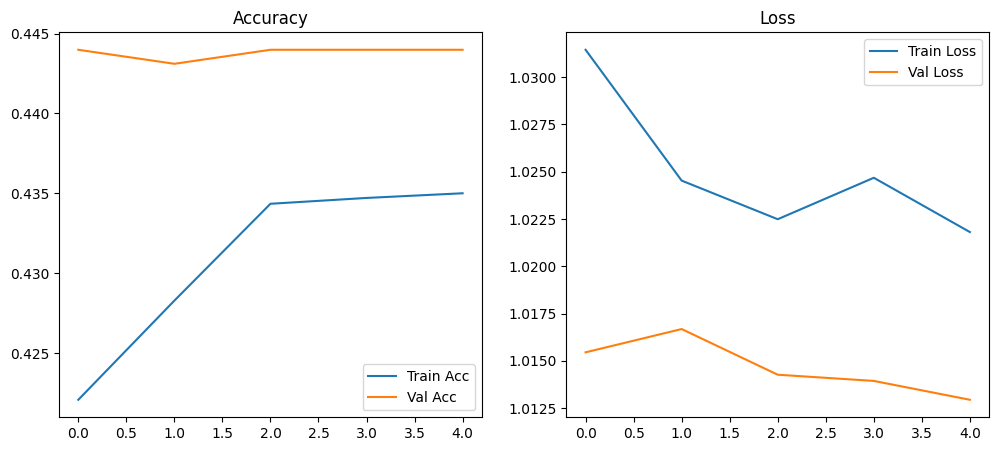

107/107 ━━━━━━━━━━━━━━━━━━━━ 106s 966ms/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.00      0.00      0.00      1378
      2COVID       0.44      1.00      0.61      1518
        3CAP       0.00      0.00      0.00       523

    accuracy                           0.44      3419
   macro avg       0.15      0.33      0.20      3419
weighted avg       0.20      0.44      0.27      3419



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


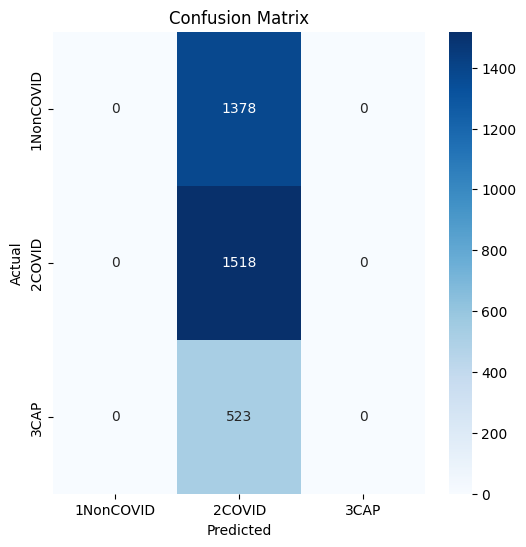

107/107 ━━━━━━━━━━━━━━━━━━━━ 101s 945ms/step - accuracy: 0.2228 - loss: 0.9122
✅ Final Accuracy: 0.4440
❌ Error Rate: 55.60%


In [ ]:
# ✅ Unzip Normalized Dataset
import zipfile

with zipfile.ZipFile("normalized_dataset_1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")

print("✅ Normalized dataset is ready!")

# 🧪 Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths (use resized 160x160 images)
data_path = "/content/normalized_dataset/curated_data"
img_size = 160
batch_size = 32

# 🔄 Data generators with normalization
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False  # freeze base for faster training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # slightly lower dropout than B3
predictions = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋️‍♂️ Train
history = model.fit(train_data, validation_data=val_data, epochs=5)

# 💾 Save model
model.save("EfficientNetB0_Optimized.h5")

# 📉 Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
